In [1]:
# -----------------------------------------------------------------------------
# 1. Imports and API wiring
# -----------------------------------------------------------------------------

import os, sys, math
import numpy as np
import torch
import matplotlib.pyplot as plt
import importlib

# Ensure local package is importable (assumes this notebook is in project root)
root = os.getcwd()
if root not in sys.path:
    sys.path.insert(0, root)

# Imports from AdaPID and GuidedPID APIs
adapid = importlib.import_module("adapid_torch")
guided = importlib.import_module("guided_torch")
CaseA  = importlib.import_module("CaseA")

print("Ada API:", adapid.__file__)
print("Guided API:", getattr(guided, "__file__", None))
print("CaseA API:", getattr(CaseA, "__file__", None))

# Convenience aliases from CaseA API
SnapshotConfig                = CaseA.SnapshotConfig
simulate_caseA_with_snapshots = CaseA.simulate_caseA_with_snapshots
build_corridor_walls          = CaseA.build_corridor_walls

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Ada API: /Users/chertkov/Dropbox/Working/NewPID/GuidePID/11_14_25/adapid_torch/__init__.py
Guided API: /Users/chertkov/Dropbox/Working/NewPID/GuidePID/11_14_25/guided_torch/__init__.py
CaseA API: /Users/chertkov/Dropbox/Working/NewPID/GuidePID/11_14_25/CaseA/__init__.py
Using device: cpu


In [2]:

# -----------------------------------------------------------------------------
# 1b. Autograd patch: redefine guided.ustar_guided WITHOUT @torch.no_grad
# -----------------------------------------------------------------------------
#
# The original guided.ustar_guided in guided_torch.py is decorated with
# @torch.no_grad(), which kills gradients w.r.t. ν. Here we define a local
# autograd-friendly version and overwrite guided.ustar_guided.
#
# For a permanent fix, remove @torch.no_grad() from ustar_guided in the
# guided_torch.py file itself.

import torch

def _as_batch_local(Z: torch.Tensor) -> torch.Tensor:
    """Ensure Z has shape (M,d) by adding a batch dimension if needed."""
    if Z.dim() == 1:
        return Z.view(1, -1)
    return Z

def ustar_guided_autograd(X, t, sched, gmm):
    r"""
    Autograd-friendly guided optimal control u^*(t,x;Γ):

        u_t^*(x;Γ) = -a^-(t) (x - ν_t)
                      + b^-(t) (ŷ(t;x;Γ) - ν_t)
                      + r^-(t).

    Shapes:
      X    : (M,d) or (d,) -> treated as (M,d)
      ν_t  : (d,)
      r^-  : (d,)
      ŷ    : (M,d)
      u    : (M,d)
    """
    # ensure shape (M, d)
    Xb = _as_batch_local(X).to(gmm.MU.device)   # (M,d)
    M, d = Xb.shape

    # scalar coefficients (treated as constants for grad purposes)
    a_m = sched.a_minus(float(t))    # a^-(t)
    b_m = sched.b_minus(float(t))    # b^-(t)

    # guidance ν_t and linear term r^-(t), both ∈ ℝ^d and carrying ν-gradients
    nu_t = sched.nu_sched.value(float(t)).to(Xb.device).view(1, d)     # (1,d)
    r_t  = sched.rsminus.r_minus(float(t)).to(Xb.device).view(1, d)    # (1,d)

    # guided oracle ŷ(t;x;Γ) ∈ ℝ^{M×d}
    yhat = guided.yhat_gmm_guided(Xb, float(t), sched, gmm)             # (M,d)

    if yhat.shape != Xb.shape:
        raise RuntimeError(
            f"ustar_guided_autograd: yhat shape {yhat.shape} "
            f"does not match X shape {Xb.shape}"
        )

    # u = -a^- (x - ν_t) + b^- (ŷ - ν_t) + r^-
    u = -a_m * (Xb - nu_t) + b_m * (yhat - nu_t) + r_t                 # (M,d)
    return u

# Overwrite guided.ustar_guided with autograd-friendly version
guided.ustar_guided = ustar_guided_autograd
print("Patched guided.ustar_guided to autograd-friendly version.")


Patched guided.ustar_guided to autograd-friendly version.



# Case B (Teacher Objective) with Autograd: PWC Optimization of ν(t)

We now switch from SPSA to **autograd**.  The key idea is:

- keep the stiffness profile fixed: β(t) = \barβ(t) (teacher),
- optimize only the guidance centerline ν(t) on a PWC grid,
- define a fully differentiable Euler–Maruyama loop that:
  - uses `guided.ustar_guided(X, t, sched, gmm)` at each step,
  - accumulates the teacher cost
    \[
      J(\nu) = \frac{1}{2} \int_0^1 \bar\beta_t
        \,\mathbb{E}\big[\|x_t - \bar\nu_t\|^2\big]\,dt,
    \]
- and minimize J(ν) with standard `torch.optim.Adam`.

We enforce ν(0) = 0 at each iteration, keep ν(1) unconstrained, and compute
the optimized PWC ν*(t).  Finally, we compare ν*(t) to the teacher \barν(t)
both numerically and via multi-panel plots.


In [3]:

# -----------------------------------------------------------------------------
# 2. Basic configuration, Case B target GMM, and intrinsic frame
# -----------------------------------------------------------------------------

import numpy as np
import torch
import matplotlib.pyplot as plt

print("Using device:", device)

# PWC configuration (you can change this to 4, 8, ...)
K_pwc = 50
splits_pwc = np.linspace(0.0, 1.0, K_pwc + 1)

# Sampling configuration
M_samples = 4000
snap_cfg_teacher_fig   = SnapshotConfig(T=3000, n_save=9)
snap_cfg_teacher_movie = SnapshotConfig(T=3000, n_save=60)

# --- Case B target GMM (2-mode or 3-mode variants) ---------------------------

def make_gmm_params_2mode_elongated():
    mu = np.array([[4.0, -0.25],
                   [3.0,  0.35]], dtype=np.float32)
    cov = np.array([[[0.10, 0.0],
                     [0.0,  0.04]],
                    [[0.05, 0.0],
                     [0.0,  0.08]]], dtype=np.float32)
    w = np.array([0.6, 0.4], dtype=np.float32)
    w /= w.sum()
    return mu, cov, w

"""
def make_gmm_params_3mode_triangular():
    mu = np.array([[5.0,  0.0],
                   [5.8,  0.5],
                   [5.8, -0.5]], dtype=np.float32)
    cov = np.array([[[0.06, 0.0],
                     [0.0,  0.04]],
                    [[0.04, 0.0],
                     [0.0,  0.04]],
                    [[0.04, 0.0],
                     [0.0,  0.04]]], dtype=np.float32)
    w = np.array([0.4, 0.3, 0.3], dtype=np.float32)
    w /= w.sum()
    return mu, cov, w
"""

def make_gmm_params_3mode_triangular():
    mu = np.array([[2.0,  0.0],
                   [2.8,  0.5],
                   [2.8, -0.5]], dtype=np.float32)
    cov = np.array([[[0.06, 0.0],
                     [0.0,  0.04]],
                    [[0.04, 0.0],
                     [0.0,  0.04]],
                    [[0.04, 0.0],
                     [0.0,  0.04]]], dtype=np.float32)
    w = np.array([0.4, 0.3, 0.3], dtype=np.float32)
    w /= w.sum()
    return mu, cov, w


CASEB_TARGET_NAME = "3mode" #"2mode"  # or "3mode"

def get_caseB_gmm(name: str):
    if name == "2mode":
        return make_gmm_params_2mode_elongated()
    elif name == "3mode":
        return make_gmm_params_3mode_triangular()
    else:
        raise ValueError(f"Unknown CaseB target name: {name!r}")

mu_tar, cov_tar, w_tar = get_caseB_gmm(CASEB_TARGET_NAME)
print(f"Case B target: {CASEB_TARGET_NAME}, modes={mu_tar.shape[0]}")

# --- Intrinsic frame: x_in, x_out, e_axis, n_axis ----------------------------

x_in  = np.zeros(2, dtype=np.float32)
x_out = np.average(mu_tar, axis=0, weights=w_tar)

v_axis = x_out - x_in
L_axis = np.linalg.norm(v_axis)
if L_axis <= 0:
    raise RuntimeError("Degenerate axis: x_in and x_out coincide.")

e_axis = v_axis / L_axis
n_axis = np.array([-e_axis[1], e_axis[0]], dtype=np.float32)

def x_axis(s: float) -> np.ndarray:
    """Point on the axis segment for progress s ∈ [0, 1]."""
    return x_in + float(s) * v_axis

print("Intrinsic frame:")
print("  x_in  =", x_in)
print("  x_out =", x_out)
print("  e_axis =", e_axis)
print("  n_axis =", n_axis)

# --- Build GMMTorch target used in GH–PID dynamics ---------------------------

MU  = torch.from_numpy(mu_tar).to(device)
COV = torch.from_numpy(cov_tar).to(device)
W   = torch.from_numpy(w_tar).to(device)
gmm_target = adapid.GMMTorch(MU, COV, W).to(device)


Using device: cpu
Case B target: 3mode, modes=3
Intrinsic frame:
  x_in  = [0. 0.]
  x_out = [2.48 0.  ]
  e_axis = [1. 0.]
  n_axis = [-0.  1.]


In [4]:

# -----------------------------------------------------------------------------
# 3. Teacher protocol (bar{β}(t), bar{ν}(t)): continuous S-curve + PWC samples
# -----------------------------------------------------------------------------
#
# Teacher centerline in the intrinsic frame:
#
#   ν_raw(t) = x_axis(t) + y(t) n_axis,
#   y(t)     = A * tanh( κ (2t - 1) ),
#
# and then we correct endpoints so that
#   barν(0) = x_in,   barν(1) = x_out.
#
# We use the *continuous* curve barν(t), barβ(t) in the optimization objective,
# but we also construct PWC samples (bar_nu_vals, bar_beta_vals) at K_pwc
# intervals for use in the GH–PID schedule and in visualizations.

rng = np.random.default_rng(seed=12345)

# Amplitude and steepness of the S-shape in the normal direction
A_swing = 3.0
kappa   = 6.0

def nu_raw(t: float) -> np.ndarray:
    """Uncorrected S-shaped teacher centerline in the intrinsic frame."""
    t = float(t)
    y = A_swing * np.tanh(kappa * (2.0 * t - 1.0))
    return (x_axis(t) + y * n_axis).astype(np.float32)

# Precompute raw endpoints to construct a linear endpoint correction
nu_raw_0 = nu_raw(0.0)
nu_raw_1 = nu_raw(1.0)

def bar_nu_cont(t: float) -> np.ndarray:
    """
    Continuous teacher curve barν(t) with enforced endpoints:
      barν(t) = nu_raw(t)
                + (1-t) * (x_in  - nu_raw(0))
                +    t  * (x_out - nu_raw(1)).
    """
    t = float(t)
    base = nu_raw(t)
    corr = (1.0 - t) * (x_in - nu_raw_0) + t * (x_out - nu_raw_1)
    return (base + corr).astype(np.float32)

# Teacher stiffness: constant in time (but we still store a PWC version)
beta_const = 20.0

def bar_beta_cont(t: float) -> float:
    """Continuous teacher stiffness barβ(t) ≡ beta_const."""
    _ = t
    return float(beta_const)

# --- PWC samples of barν(t) and barβ(t) at midpoints of each interval --------

bar_nu_vals = np.zeros((K_pwc, 2), dtype=np.float32)
for k in range(K_pwc):
    t_mid = 0.5 * (splits_pwc[k] + splits_pwc[k+1])
    bar_nu_vals[k, :] = bar_nu_cont(t_mid)

# Enforce exact boundary values at t=0 and t=1
bar_nu_vals[0, :]  = x_in
bar_nu_vals[-1, :] = x_out

# PWC β is simply constant at all intervals
bar_beta_vals = np.full(K_pwc, beta_const, dtype=np.float32)

print("Teacher bar_nu_vals (PWC samples of continuous S-curve, fixed endpoints):")
print(bar_nu_vals)
print("Teacher bar_beta_vals (PWC, constant):", bar_beta_vals)

# -------------------------------------------------------------------------
# Helper: generic PWC evaluation, used only for plotting / diagnostics.
# GH–PID dynamics (ustar_guided) *always* use the PWC profiles via
# BetaSchedulePWCTorch and NuPWC.
# -------------------------------------------------------------------------

def eval_pwc_profile(t: float, splits: np.ndarray, values: np.ndarray):
    """Evaluate a PWC profile defined by 'values' on intervals 'splits'."""
    t = float(np.clip(t, 0.0, 1.0))
    if t >= 1.0:
        return values[-1]
    idx = np.searchsorted(splits, t, side="right") - 1
    idx = int(np.clip(idx, 0, len(values) - 1))
    return values[idx]

def eval_teacher_nu_beta(t: float):
    """
    Return (bar_nu_t, bar_beta_t) under the teacher protocol at time t,
    using the *continuous* teacher formulas bar_nu_cont, bar_beta_cont.
    These are used only in the optimization objective, not in the schedule.
    """
    bar_nu_t = bar_nu_cont(t)
    bar_beta_t = bar_beta_cont(t)
    return np.asarray(bar_nu_t, dtype=np.float32), float(bar_beta_t)


Teacher bar_nu_vals (PWC samples of continuous S-curve, fixed endpoints):
[[ 0.          0.        ]
 [ 0.0744     -0.17995882]
 [ 0.12400001 -0.29991102]
 [ 0.1736     -0.4198339 ]
 [ 0.22320001 -0.5397105 ]
 [ 0.2728     -0.65951204]
 [ 0.3224     -0.77919245]
 [ 0.372      -0.8986769 ]
 [ 0.4216     -1.0178449 ]
 [ 0.4712     -1.1365013 ]
 [ 0.5208     -1.2543323 ]
 [ 0.5704     -1.3708313 ]
 [ 0.62       -1.4851825 ]
 [ 0.6696     -1.5960778 ]
 [ 0.71919996 -1.701423  ]
 [ 0.7688     -1.7978919 ]
 [ 0.8184     -1.8802545 ]
 [ 0.868      -1.9404292 ]
 [ 0.91760004 -1.9662709 ]
 [ 0.9672     -1.9403598 ]
 [ 1.0168     -1.8396039 ]
 [ 1.0664     -1.6374323 ]
 [ 1.1159999  -1.3111523 ]
 [ 1.1656001  -0.85564446]
 [ 1.2152001  -0.29828268]
 [ 1.2648      0.29828268]
 [ 1.3144      0.85564446]
 [ 1.3640001   1.3111523 ]
 [ 1.4136      1.6374323 ]
 [ 1.4632      1.8396039 ]
 [ 1.5128001   1.9403598 ]
 [ 1.5624      1.9662709 ]
 [ 1.612       1.9404292 ]
 [ 1.6616001   1.8802545 ]
 [ 1.711

In [5]:
# -----------------------------------------------------------------------------
# 4. Autograd-based objective: GH–PID simulation with teacher + CE cost
# -----------------------------------------------------------------------------
#
# We define a differentiable objective J(ν) by simulating GH–PID with
# piecewise-constant ν(t) (and fixed β(t) = barβ(t)), and accumulating:
#
#   (i)  Teacher cost:
#        J_teacher(ν) = (1/2) ∫_0^1 barβ_t E[ ||x_t - barν_t||^2 ] dt
#
#   (ii) Cross-entropy regularizer at final time:
#        J_CE(ν) = - E_{x_T}[ log ρ_target(x_T) ]
#
# so that
#
#   J(ν) = J_teacher(ν) + λ_CE J_CE(ν).
#
# Important:
# - In Cell 1 we patched guided.ustar_guided to be autograd-friendly.
#   Here we just call guided.ustar_guided.
# - gmm_target.SIG can be full covariance (K,d,d), which is supported by
#   guided.yhat_gmm_guided, but NOT by adapid.logpdf_gmm_torch. Therefore,
#   we define a local logpdf that reduces full covariance to its diagonal.
# -----------------------------------------------------------------------------

lambda_ce = 0.1  # weight of the cross-entropy regularizer (tune as needed)

def logpdf_gmm_diag_like(gmm, X: torch.Tensor) -> torch.Tensor:
    """
    Log-density of a GMM with (possibly full) covariance, approximated as
    diagonal. Compatible with the shapes handled in guided.yhat_gmm_guided:

      MU  : (K,d)
      SIG : (K,), (K,d) or (K,d,d)
      PI  : (K,)

    X can be (M,d) or (d,); returns shape (M,).
    """
    MU  = gmm.MU.to(X.device)   # (K,d)
    SIG = gmm.SIG.to(X.device)  # (K,...) possibly full cov
    PI  = gmm.PI.to(X.device)   # (K,)

    # Ensure 2D shape for X: (M,d)
    if X.ndim == 1:
        Xb = X.view(1, -1)
    elif X.ndim == 2:
        Xb = X
    else:
        raise RuntimeError(f"logpdf_gmm_diag_like: unexpected X shape {X.shape}")

    K, d = MU.shape

    # ---- Build diagonal variance matrix var_diag of shape (K,d) ----
    if SIG.ndim == 3:
        # Full covariance: take diagonal Σ_{n,kk}
        var_diag = torch.diagonal(SIG, dim1=1, dim2=2)  # (K,d)
    elif SIG.ndim == 2:
        # Interpret as per-dimension std devs
        var_diag = SIG ** 2                             # (K,d)
    elif SIG.ndim == 1:
        # One std per component; expand across dimensions
        var_diag = (SIG ** 2).unsqueeze(-1)             # (K,1)
    else:
        raise RuntimeError(f"logpdf_gmm_diag_like: unexpected SIG shape {SIG.shape}")

    if var_diag.shape != MU.shape:
        var_diag = var_diag.expand_as(MU)               # (K,d)

    # ---------- Quadratic term per component ----------
    # Xb: (M,d), MU: (K,d) -> delta: (M,K,d)
    delta = Xb.unsqueeze(1) - MU.unsqueeze(0)           # (M,K,d)
    quad = 0.5 * (delta * delta / (var_diag.unsqueeze(0) + 1e-32)).sum(dim=-1)  # (M,K)

    # ---------- Normalization term per component ----------
    # log det Σ_n = sum_k log var_diag_{n,k}
    log_det = torch.log(var_diag + 1e-32).sum(dim=-1)   # (K,)
    log_norm = -0.5 * (d * math.log(2*math.pi) + log_det)  # (K,)

    # ---------- Combine with mixture weights ----------
    log_pi = torch.log(PI + 1e-32)                      # (K,)

    # log p_n(x) = log_norm_n - quad_{m,n}
    # log p(x) = logsumexp_n [ log p_n(x) + log π_n ]
    log_comp = log_norm.unsqueeze(0) - quad             # (M,K)
    lse = torch.logsumexp(log_comp + log_pi.unsqueeze(0), dim=1)  # (M,)

    return lse


def build_schedule_from_pwc_autograd(
    beta_vals_np: np.ndarray,
    nu_vals_t: torch.Tensor,
    d: int,
    device: torch.device,
):
    """
    Construct a GuidedPWCSchedule from
      - beta_vals_np : (K,)
      - nu_vals_t    : (K,d) torch (trainable)
    """
    beta_vals_np = np.asarray(beta_vals_np, dtype=np.float32)

    beta_sched = guided.BetaSchedulePWCTorch(beta_vals_np, splits_pwc)
    nu_sched   = guided.NuPWC(
        values=nu_vals_t,  # carries gradients
        splits=torch.tensor(splits_pwc, dtype=torch.float32, device=device),
    )
    rsminus = guided.build_rsminus_pwc(beta_sched, nu_sched, d=d, device=device)
    splus1  = guided.s_plus_terminal(beta_sched, nu_sched, d=d, device=device)
    return guided.GuidedPWCSchedule(
        beta_sched=beta_sched,
        nu_sched=nu_sched,
        rsminus=rsminus,
        splus1=splus1,
    )


def simulate_and_teacher_cost_autograd(
    nu_vals_t: torch.Tensor,
    T: int = 400,
    M: int = M_samples,
    seed: int = 1234,
    device: torch.device = device,
    lambda_ce: float = lambda_ce,
) -> torch.Tensor:
    """
    Simulate GH–PID paths under (barβ, ν) and accumulate

        J(ν) = J_teacher(ν) + λ_CE J_CE(ν),

    with
      J_teacher(ν) = (1/2) ∫_0^1 barβ_t E[ ||x_t - barν_t||^2 ] dt
      J_CE(ν)      = - E_{x_T}[ log ρ_target(X_T) ].

    Returns a scalar tensor (with grad w.r.t. nu_vals_t).
    """
    # Build schedule: β fixed to barβ_vals, ν = nu_vals_t
    sched = build_schedule_from_pwc_autograd(bar_beta_vals, nu_vals_t, d=2, device=device)

    # Initialize state
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    gmm = gmm_target.to(device)
    X = torch.zeros((M, gmm.d), device=device)

    dt  = 1.0 / T
    sdt = math.sqrt(dt)

    J_accum = torch.zeros((), device=device)

    for n in range(T):
        t_n   = n * dt
        t_np1 = (n + 1) * dt
        t_mid = 0.5 * (t_n + t_np1)

        # GH–PID drift u^*(t_mid, X; Γ)
        # NOTE: guided.ustar_guided is already patched to be autograd-friendly.
        u = guided.ustar_guided(X, float(t_mid), sched, gmm)
        if not torch.isfinite(u).all():
            raise RuntimeError(f"Non-finite control at step {n}, t={t_mid}")

        # Euler–Maruyama step
        dW = torch.randn_like(X) * sdt
        X  = X + u * dt + dW
        if not torch.isfinite(X).all():
            raise RuntimeError(f"Non-finite state at step {n}, t={t_np1}")

        # Teacher cost at time t_mid
        bar_nu_t, bar_beta_t = eval_teacher_nu_beta(float(t_mid))
        bar_nu_t_t = torch.tensor(bar_nu_t, dtype=torch.float32, device=device).view(1, -1)
        diff   = X - bar_nu_t_t
        sqdist = (diff * diff).sum(dim=-1)     # shape (M,)
        cost_t = 0.5 * float(bar_beta_t) * sqdist.mean()
        J_accum = J_accum + cost_t * dt

    # -------------------------------------------------------------------------
    # Cross-entropy regularizer at final time: J_CE = -E[log ρ_target(X_T)]
    # -------------------------------------------------------------------------
    logp_target = logpdf_gmm_diag_like(gmm, X)   # shape (M,)
    J_ce = - logp_target.mean()
    J_accum = J_accum + lambda_ce * J_ce

    return J_accum


# For reference, evaluate the cost at the teacher ν (no optimization yet)
with torch.no_grad():
    nu_teacher_t = torch.tensor(bar_nu_vals, dtype=torch.float32, device=device)
    J_teacher = simulate_and_teacher_cost_autograd(
        nu_teacher_t,
        T=400,
        M=M_samples,
        seed=1234,
        device=device,
        lambda_ce=lambda_ce,
    )
    print(f"[Autograd] J(barν) with CE ≈ {J_teacher.item():.4f}")


[Autograd] J(barν) with CE ≈ 13.2640


In [6]:

# -----------------------------------------------------------------------------
# 5. Autograd optimization over PWC ν (β fixed = barβ) with adaptive step size
# -----------------------------------------------------------------------------
#
# We treat ν_vals as a torch.nn.Parameter of shape (K_pwc, 2) and minimize
#   J(ν) = J_state(ν) + λ_ν * ∑_k ||ν_k - barν_k||^2,
# where J_state(ν) is obtained from simulate_and_teacher_cost_autograd.
#
# Key features:
#   - initialize at the teacher ν (barν),
#   - pin ν(0) = x_in after each step,
#   - keep β(t) fixed to barβ_vals in the schedule,
#   - add a mild regularizer toward the teacher barν to avoid wild excursions,
#   - use Adam *with an adaptive learning rate*: if the objective fails to
#     improve for several iterations, we reduce the step size.

# Initialize ν as trainable parameter (starting from teacher)
nu_init = torch.tensor(bar_nu_vals, dtype=torch.float32, device=device)
nu_init[0, :] = torch.tensor(x_in, dtype=torch.float32, device=device)  # enforce ν(0)=x_in

nu_param = torch.nn.Parameter(nu_init.clone())
bar_nu_tensor = torch.tensor(bar_nu_vals, dtype=torch.float32, device=device)

# Regularization weight toward teacher
lambda_reg_nu = 0.1

# Adam optimizer with initial learning rate
initial_lr   = 0.2
min_lr       = 1e-3
lr_decay     = 0.5    # multiply lr by this when we decide to reduce it
lr_patience  = 10     # number of non-improving iterations before lowering lr

optimizer_nu = torch.optim.Adam([nu_param], lr=initial_lr)

# Histories and tracking
J_hist      = []
reg_hist    = []
lr_hist     = []

best_J      = float("inf")
best_nu     = None
best_iter   = -1
no_improve  = 0

# Early-stopping parameters (still relaxed)
max_iters   = 120
min_iters   = 40
patience_es = 40
tol         = 1e-3   # relative improvement threshold

for it in range(max_iters):
    optimizer_nu.zero_grad()

    # State-dependent part of the cost (teacher objective)
    J_state = simulate_and_teacher_cost_autograd(
        nu_param,
        T=400,
        M=M_samples,
        seed=1234,
        device=device,
        lambda_ce=lambda_ce,   # optional; could omit if you keep default
    )

    # Regularizer toward teacher PWC ν
    reg = ((nu_param - bar_nu_tensor)**2).sum(dim=1).mean()

    loss = J_state + lambda_reg_nu * reg
    loss.backward()
    optimizer_nu.step()

    # Enforce boundary condition ν(0) = x_in
    with torch.no_grad():
        nu_param[0, :] = torch.tensor(x_in, dtype=torch.float32, device=device)

    J_scalar = float(loss.item())
    J_hist.append(J_scalar)
    reg_hist.append(float(reg.item()))
    lr_hist.append(optimizer_nu.param_groups[0]["lr"])

    # Check improvement vs best_J
    if J_scalar + tol < best_J:
        best_J = J_scalar
        best_nu = nu_param.detach().clone()
        best_iter = it
        no_improve = 0
    else:
        no_improve += 1

    # Adaptive learning rate: if no improvement for lr_patience steps,
    # reduce lr by lr_decay (but not below min_lr).
    if no_improve >= lr_patience:
        old_lr = optimizer_nu.param_groups[0]["lr"]
        new_lr = max(min_lr, old_lr * lr_decay)
        if new_lr < old_lr - 1e-12:
            optimizer_nu.param_groups[0]["lr"] = new_lr
            print(f"[Autograd-Adam] Reducing lr: {old_lr:.4g} -> {new_lr:.4g} at iter {it}.")
        no_improve = 0  # reset counter

    print(f"[Autograd-Adam] Iter {it:3d}: "
          f"J_state={J_state.item():.4f}, reg={reg.item():.4f}, "
          f"J_total={loss.item():.4f}, lr={optimizer_nu.param_groups[0]['lr']:.4g}, "
          f"(best={best_J:.4f} at iter {best_iter})")

    # Relaxed early stopping: allow some saturation before stopping
    if it >= min_iters and (it - best_iter) >= patience_es:
        print(f"[Autograd-Adam] Early stopping at iter {it} "
              f"(no improvement better than tol for {patience_es} steps after iter {best_iter}).")
        break

# Final optimized ν*
if best_nu is None:
    best_nu = nu_param.detach().clone()

nu_opt = best_nu.cpu().numpy().astype(np.float32)
beta_opt = bar_beta_vals.copy()  # β is kept fixed here and used only as PWC

print("\n[Autograd-Adam] Best objective value found:", best_J)


[Autograd-Adam] Iter   0: J_state=13.2640, reg=0.0000, J_total=13.2640, lr=0.2, (best=13.2640 at iter 0)
[Autograd-Adam] Iter   1: J_state=11.3496, reg=0.0784, J_total=11.3575, lr=0.2, (best=11.3575 at iter 1)
[Autograd-Adam] Iter   2: J_state=10.1633, reg=0.2795, J_total=10.1912, lr=0.2, (best=10.1912 at iter 2)
[Autograd-Adam] Iter   3: J_state=9.1990, reg=0.5495, J_total=9.2539, lr=0.2, (best=9.2539 at iter 3)
[Autograd-Adam] Iter   4: J_state=8.3608, reg=0.8655, J_total=8.4473, lr=0.2, (best=8.4473 at iter 4)
[Autograd-Adam] Iter   5: J_state=7.6134, reg=1.2274, J_total=7.7361, lr=0.2, (best=7.7361 at iter 5)
[Autograd-Adam] Iter   6: J_state=6.9355, reg=1.6360, J_total=7.0991, lr=0.2, (best=7.0991 at iter 6)
[Autograd-Adam] Iter   7: J_state=6.3213, reg=2.0899, J_total=6.5303, lr=0.2, (best=6.5303 at iter 7)
[Autograd-Adam] Iter   8: J_state=5.7716, reg=2.5902, J_total=6.0306, lr=0.2, (best=6.0306 at iter 8)
[Autograd-Adam] Iter   9: J_state=5.2957, reg=3.1343, J_total=5.6092, lr=

[Saved] results_caseB/objective_history.png


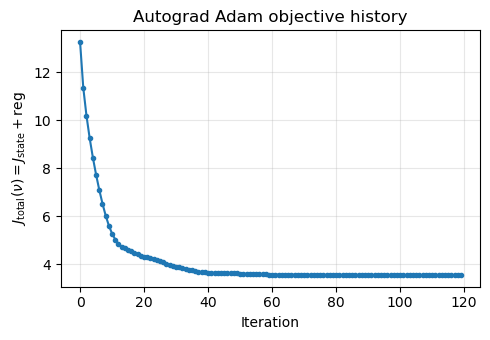

Number of iterations run: 120
Best J_total(ν): 3.5501


In [27]:
# -----------------------------------------------------------------------------
# 6. Diagnostics: objective history over autograd iterations
# -----------------------------------------------------------------------------

J_hist_arr = np.array(J_hist, dtype=np.float64)

plt.figure(figsize=(5, 3.5))
plt.plot(np.arange(J_hist_arr.size), J_hist_arr,
         marker="o", markersize=3)
plt.xlabel("Iteration")
plt.ylabel(r"$J_{\text{total}}(\nu) = J_{\text{state}} + \text{reg}$")
plt.title("Autograd Adam objective history")
plt.grid(alpha=0.3)
plt.tight_layout()

# --- Save figure -------------------------------------------------------------
import os
os.makedirs("results_caseB", exist_ok=True)
objhist_path = "results_caseB/objective_history.png"
plt.savefig(objhist_path, dpi=150)
print(f"[Saved] {objhist_path}")

plt.show()

print(f"Number of iterations run: {J_hist_arr.size}")
print(f"Best J_total(ν): {J_hist_arr.min():.4f}")


[Saved] results_caseB/nu_opt_vs_t.png


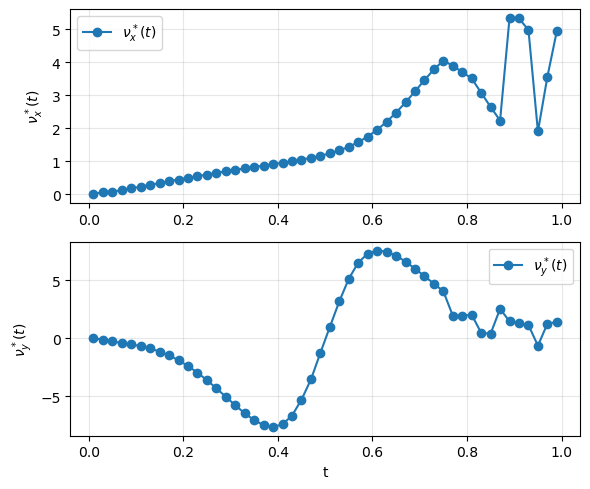

In [26]:
# -----------------------------------------------------------------------------
# 6b. Optimized protocol components: ν*_x(t) and ν*_y(t) vs t
# -----------------------------------------------------------------------------
#
# We plot the optimized guidance ν*(t) in terms of its PWC midpoints:
#   - Top panel:  ν*_x(t_k) vs t_k
#   - Bottom:     ν*_y(t_k) vs t_k
# where t_k are the midpoints of the PWC intervals defined by splits_pwc.
# -----------------------------------------------------------------------------

import os

# Get optimized ν* values as numpy array (K_pwc, 2)
if "nu_opt_vals" not in globals():
    if "nu_opt" in globals():
        nu_opt_vals = np.asarray(nu_opt, dtype=np.float32)
    elif "nu_param" in globals():
        nu_opt_vals = nu_param.detach().cpu().numpy().astype(np.float32)
    else:
        raise RuntimeError("Cannot find optimized ν*: please ensure nu_opt or nu_param is defined.")

# Midpoint times for each PWC interval
# splits_pwc has shape (K_pwc+1,)
t_mid = 0.5 * (splits_pwc[:-1] + splits_pwc[1:])  # shape (K_pwc,)

# Sanity check
assert nu_opt_vals.shape[0] == t_mid.shape[0], "Mismatch between K_pwc in ν* and splits_pwc."

nu_x_opt = nu_opt_vals[:, 0]
nu_y_opt = nu_opt_vals[:, 1]

plt.figure(figsize=(6, 5))

# --- ν*_x vs t ---------------------------------------------------------------
plt.subplot(2, 1, 1)
plt.plot(t_mid, nu_x_opt, "o-", label=r"$\nu_x^*(t)$")
plt.ylabel(r"$\nu_x^*(t)$")
plt.grid(alpha=0.3)
plt.legend()

# --- ν*_y vs t ---------------------------------------------------------------
plt.subplot(2, 1, 2)
plt.plot(t_mid, nu_y_opt, "o-", label=r"$\nu_y^*(t)$")
plt.xlabel("t")
plt.ylabel(r"$\nu_y^*(t)$")
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()

# Save figure
os.makedirs("results_caseB", exist_ok=True)
centerline_path = "results_caseB/nu_opt_vs_t.png"
plt.savefig(centerline_path, dpi=150)
print(f"[Saved] {centerline_path}")

plt.show()


[Snapshots] T=1500, requested-panels=10, M=4000
[Optimized] #snaps_raw = 9
[Base] #snaps_raw = 9
[Snapshots] Using n_panels = 10
[Figure] Saved to: results_caseB/caseB_snapshots_opt_vs_base_with_guidance_fixedAxes.png


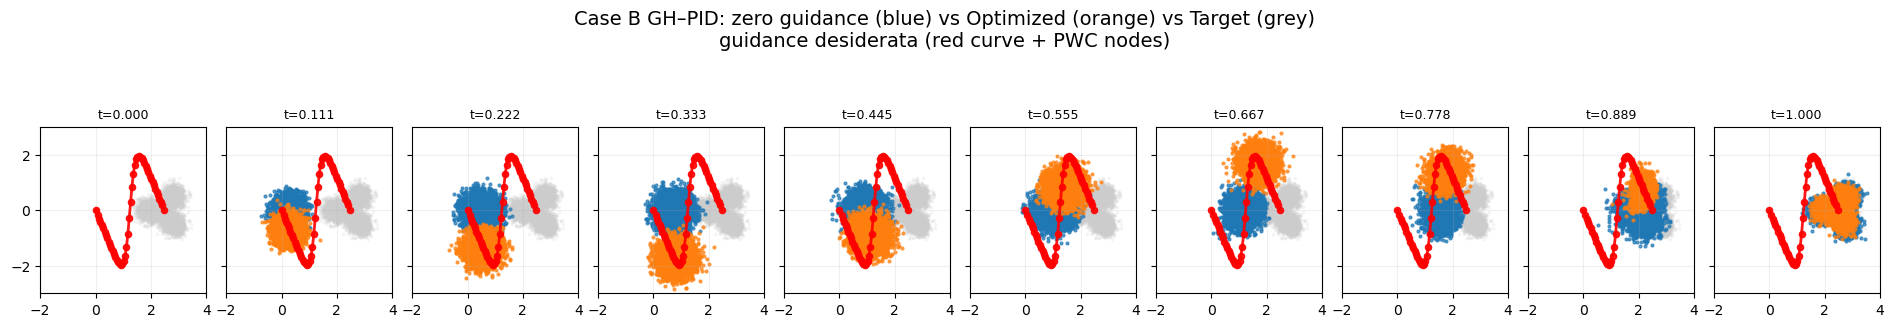

In [21]:
# -----------------------------------------------------------------------------
# Multi-panel snapshots (1×N):
#   Grey  = target GMM
#   Blue  = Γ=0 samples
#   Orange= optimized samples
#
# Teacher guidance:
#   - continuous red curve
#   - red PWC nodes
#
# Fixed view:
#   x ∈ [−2,4],  y ∈ [−3,3]
#
# Includes t = 0 snapshot (prepended).
# Also (re)builds sched_opt and sched_base if they don't exist.
# -----------------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import os

# ---------- Utilities ---------------------------------------------------------

def sample_gmm(mu_np, cov_np, w_np, n_samples, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    mu_np  = np.asarray(mu_np, dtype=float)
    cov_np = np.asarray(cov_np, dtype=float)
    w_np   = np.asarray(w_np, dtype=float)
    w_np   = w_np / w_np.sum()

    N, d = mu_np.shape
    comps = rng.choice(N, size=n_samples, p=w_np)
    X = np.zeros((n_samples, d), dtype=float)
    for j in range(N):
        idx = np.where(comps == j)[0]
        if idx.size > 0:
            X[idx] = rng.multivariate_normal(mu_np[j], cov_np[j], size=idx.size)
    return X

def mass_near_origin(X, r=0.2):
    X_np = np.asarray(X, dtype=float)
    return float(np.mean(np.linalg.norm(X_np, axis=1) <= r))

def eval_teacher_curve(t_grid):
    arr = np.zeros((len(t_grid),2), dtype=float)
    for i,t in enumerate(t_grid):
        arr[i,:] = bar_nu_cont(float(t))
    return arr

# ---------- Ensure schedules exist -------------------------------------------

def build_schedule_from_pwc_numpy(
    beta_vals_np: np.ndarray,
    nu_vals_np: np.ndarray,
    d: int,
    device: torch.device,
):
    beta_vals_np = np.asarray(beta_vals_np, dtype=np.float32)
    nu_vals_np   = np.asarray(nu_vals_np,   dtype=np.float32)

    beta_sched = guided.BetaSchedulePWCTorch(beta_vals_np, splits_pwc)
    nu_sched   = guided.NuPWC(
        values=torch.tensor(nu_vals_np, dtype=torch.float32, device=device),
        splits=torch.tensor(splits_pwc, dtype=torch.float32, device=device),
    )
    rsminus = guided.build_rsminus_pwc(beta_sched, nu_sched, d=d, device=device)
    splus1  = guided.s_plus_terminal(beta_sched, nu_sched, d=d, device=device)
    return guided.GuidedPWCSchedule(
        beta_sched=beta_sched,
        nu_sched=nu_sched,
        rsminus=rsminus,
        splus1=splus1,
    )

# Base \nu=0 protocol ν_base(t) along axis, if not already there
if "nu_base_vals" not in globals():
    def nu_base_cont(t: float) -> np.ndarray:
        return x_axis(float(t)).astype(np.float32)

    nu_base_vals = np.zeros((K_pwc, 2), dtype=np.float32)
    for k in range(K_pwc):
        t_mid = 0.5 * (splits_pwc[k] + splits_pwc[k+1])
        nu_base_vals[k, :] = nu_base_cont(t_mid)
    nu_base_vals[0, :]  = x_in
    nu_base_vals[-1, :] = x_out

beta_base_vals = bar_beta_vals.copy()

# Build sched_base if needed
if "sched_base" not in globals():
    sched_base = build_schedule_from_pwc_numpy(beta_base_vals, nu_base_vals, d=2, device=device)

# Build sched_opt from optimized ν if needed
if "sched_opt" not in globals():
    if "nu_opt" in globals():
        nu_opt_vals = np.asarray(nu_opt, dtype=np.float32)
    elif "nu_param" in globals():
        nu_opt_vals = nu_param.detach().cpu().numpy().astype(np.float32)
    else:
        raise RuntimeError("Cannot build sched_opt: nu_opt or nu_param not found. Run optimization first.")
    sched_opt = build_schedule_from_pwc_numpy(bar_beta_vals, nu_opt_vals, d=2, device=device)

# ---------- Background target samples ----------------------------------------

rng_vis = np.random.default_rng(2025)
X_tar = sample_gmm(mu_tar, cov_tar, w_tar, 4000, rng_vis)

# Snapshot configuration
T_snap   = 1500
n_panels_request = 10
snap_cfg = SnapshotConfig(T=T_snap, n_save=n_panels_request)

print(f"[Snapshots] T={T_snap}, requested-panels={n_panels_request}, M={M_samples}")

# Simulate raw snapshots
snaps_opt_raw = simulate_caseA_with_snapshots(
    sched_opt,
    gmm_target,
    M=M_samples,
    snap_cfg=snap_cfg,
    seed=1111,
    device=device,
)
snaps_base_raw = simulate_caseA_with_snapshots(
    sched_base,
    gmm_target,
    M=M_samples,
    snap_cfg=snap_cfg,
    seed=3333,
    device=device,
)

print(f"[Optimized] #snaps_raw = {len(snaps_opt_raw)}")
print(f"[Base] #snaps_raw = {len(snaps_base_raw)}")

# ---------- Prepend t=0 snapshot ---------------------------------------------

def prepend_t0_snapshot(snaps_raw, M):
    X0 = np.zeros((M,2), dtype=float)
    t0 = 0.0
    return [{"t": t0, "X": X0}] + snaps_raw

snaps_opt  = prepend_t0_snapshot(snaps_opt_raw,  M_samples)
snaps_base = prepend_t0_snapshot(snaps_base_raw, M_samples)

n_panels = min(len(snaps_opt), len(snaps_base))
print(f"[Snapshots] Using n_panels = {n_panels}")

# ---------- Build figure ------------------------------------------------------

fig, axes = plt.subplots(
    1, n_panels,
    figsize=(1.9*n_panels, 3.6),
    sharex=True, sharey=True
)
if n_panels == 1:
    axes = np.array([axes])

# Teacher continuous guidance (red)
t_dense = np.linspace(0, 1, 300)
teacher_curve = eval_teacher_curve(t_dense)
teacher_nodes = bar_nu_vals.copy()

# ---------- Populate panels ---------------------------------------------------

for j in range(n_panels):
    ax = axes[j]

    X_opt  = snaps_opt[j]["X"]
    X_base = snaps_base[j]["X"]
    t_snap = snaps_opt[j]["t"]

    # Target (grey)
    ax.scatter(X_tar[:,0], X_tar[:,1], s=3, alpha=0.15, color="0.8")

    # Base blue cloud
    ax.scatter(X_base[:,0], X_base[:,1], s=4, alpha=0.7, color="tab:blue")

    # Optimized orange cloud
    ax.scatter(X_opt[:,0],  X_opt[:,1],  s=4, alpha=0.7, color="tab:orange")

    # Teacher guidance
    ax.plot(
        teacher_curve[:,0],
        teacher_curve[:,1],
        color="red", linewidth=2.0, alpha=0.9
    )
    ax.scatter(
        teacher_nodes[:,0],
        teacher_nodes[:,1],
        color="red",
        s=20,
        zorder=5,
        alpha=0.9
    )

    ax.set_title(f"t={t_snap:.3f}", fontsize=9)
    ax.set_aspect("equal", "box")
    ax.grid(alpha=0.2)

# ---------- Fixed axes: x ∈ [−2,4], y ∈ [−2,2] -------------------------------

for ax in axes:
    ax.set_xlim(-2, 4)
    ax.set_ylim(-3, 3)

fig.suptitle(
    "Case B GH–PID: zero guidance (blue) vs Optimized (orange) vs Target (grey)\n"
    "guidance desiderata (red curve + PWC nodes)",
    fontsize=14
)
plt.tight_layout()

os.makedirs("results_caseB", exist_ok=True)
out_path = "results_caseB/caseB_snapshots_opt_vs_base_with_guidance_fixedAxes.png"
fig.savefig(out_path, dpi=200, bbox_inches="tight")
print(f"[Figure] Saved to:", out_path)

plt.show()


In [23]:
# -----------------------------------------------------------------------------
# Movie: Γ=0 (blue) vs optimized (orange) vs target (grey) + Teacher guidance
# -----------------------------------------------------------------------------
#
# Each frame shows:
#   - grey: target GMM samples,
#   - blue: Γ=0 base protocol samples,
#   - orange: optimized protocol samples,
#   - red: teacher guidance (continuous curve + PWC nodes).
#
# The movie is also saved as an MP4 in results_caseB/.
# -----------------------------------------------------------------------------

from matplotlib import animation
from IPython.display import HTML, display
import os

print("[Movie] Building combined movie: Γ=0 (blue) vs optimized (orange) + teacher (red)...")

# High-res snapshot configuration for the movie
T_movie   = 2000
n_frames  = 80
snap_cfg_movie = SnapshotConfig(T=T_movie, n_save=n_frames)

# Re-simulate optimized protocol
snaps_opt_movie = simulate_caseA_with_snapshots(
    sched_opt,
    gmm_target,
    M=M_samples,
    snap_cfg=snap_cfg_movie,
    seed=5555,
    device=device,
)
snaps_opt_movie  = prepend_t0_snapshot(snaps_opt_movie, M_samples)

# Re-simulate base Γ=0 protocol
snaps_base_movie = simulate_caseA_with_snapshots(
    sched_base,
    gmm_target,
    M=M_samples,
    snap_cfg=snap_cfg_movie,
    seed=7777,
    device=device,
)
snaps_base_movie = prepend_t0_snapshot(snaps_base_movie, M_samples)

# Ensure same number of frames
n_frames_eff = min(len(snaps_opt_movie), len(snaps_base_movie))
snaps_opt_movie  = snaps_opt_movie[:n_frames_eff]
snaps_base_movie = snaps_base_movie[:n_frames_eff]
print(f"[Movie] Using n_frames(effective) = {n_frames_eff}")

# Teacher guidance (continuous + PWC nodes)
def eval_teacher_curve(t_grid):
    arr = np.zeros((len(t_grid), 2), dtype=float)
    for i, t in enumerate(t_grid):
        arr[i, :] = bar_nu_cont(float(t))
    return arr

t_dense = np.linspace(0, 1, 300)
teacher_curve = eval_teacher_curve(t_dense)   # (n_grid, 2)
teacher_nodes = bar_nu_vals.copy()           # (K_pwc, 2)

# Infer axis limits from all frames + target + teacher curve
all_x = [X_tar[:, 0], teacher_curve[:, 0]]
all_y = [X_tar[:, 1], teacher_curve[:, 1]]
for snaps in (snaps_opt_movie, snaps_base_movie):
    for snap in snaps:
        Xf = np.asarray(snap["X"], dtype=float)
        all_x.append(Xf[:, 0])
        all_y.append(Xf[:, 1])

x_min = float(min(np.min(a) for a in all_x))
x_max = float(max(np.max(a) for a in all_x))
y_min = float(min(np.min(a) for a in all_y))
y_max = float(max(np.max(a) for a in all_y))

# Ensure origin and some left room included
x_min = min(x_min, 0.0)
y_min = min(y_min, 0.0)
dx = 0.05 * (x_max - x_min + 1e-8)
dy = 0.05 * (y_max - y_min + 1e-8)
xlim = (x_min - dx, x_max + dx)
ylim = (y_min - dy, y_max + dy)

def make_ghpid_movie_opt_vs_base_with_teacher(
    snaps_opt,
    snaps_base,
    X_tar,
    teacher_curve,
    teacher_nodes,
    title: str,
    xlim,
    ylim,
    interval: int = 80,
):
    X_tar_np = np.asarray(X_tar, dtype=float)
    fig, ax = plt.subplots(figsize=(5, 4))
    fig.suptitle(title, fontsize=14)

    # Background target (grey)
    ax.scatter(X_tar_np[:, 0], X_tar_np[:, 1],
               s=3, alpha=0.2, color="0.8", label="Target")

    # Teacher continuous curve (red)
    ax.plot(
        teacher_curve[:, 0],
        teacher_curve[:, 1],
        color="red",
        linewidth=2.0,
        alpha=0.9,
        label="desiderata"
    )

    # Teacher PWC nodes (red dots)
    ax.scatter(
        teacher_nodes[:, 0],
        teacher_nodes[:, 1],
        color="red",
        s=20,
        zorder=5,
        alpha=0.9
    )

    # Initial clouds
    Xb0 = np.asarray(snaps_base[0]["X"], dtype=float)
    Xo0 = np.asarray(snaps_opt[0]["X"],  dtype=float)

    scat_base = ax.scatter(Xb0[:, 0], Xb0[:, 1],
                           s=3, alpha=0.8, color="tab:blue", label="Γ=0 base")
    scat_opt  = ax.scatter(Xo0[:, 0], Xo0[:, 1],
                           s=3, alpha=0.8, color="tab:orange", label="Optimized")

    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_aspect("equal", "box")
    ax.grid(alpha=0.2)
    ax.legend(loc="upper right", fontsize=9)

    def update(frame_idx):
        snap_b = snaps_base[frame_idx]
        snap_o = snaps_opt[frame_idx]
        Xb = np.asarray(snap_b["X"], dtype=float)
        Xo = np.asarray(snap_o["X"], dtype=float)
        scat_base.set_offsets(Xb)
        scat_opt.set_offsets(Xo)
        ax.set_title(f"t={snap_o['t']:.4f}", fontsize=11)
        return scat_base, scat_opt

    anim = animation.FuncAnimation(
        fig,
        update,
        frames=len(snaps_opt),
        interval=interval,
        blit=True,
    )
    plt.close(fig)
    return anim

interval_ms = 80
anim_combined = make_ghpid_movie_opt_vs_base_with_teacher(
    snaps_opt_movie,
    snaps_base_movie,
    X_tar,
    teacher_curve,
    teacher_nodes,
    title="Case B",
    xlim=xlim,
    ylim=ylim,
    interval=interval_ms,
)

# Show in notebook
display(HTML(anim_combined.to_jshtml()))

# Save as MP4
os.makedirs("results_caseB", exist_ok=True)
mp4_path = os.path.join("results_caseB", "caseB_movie_opt_vs_base_with_teacher.mp4")

try:
    from matplotlib.animation import FFMpegWriter
    fps = max(1, int(1000 / interval_ms))
    writer = FFMpegWriter(fps=fps, bitrate=2000)
    anim_combined.save(mp4_path, writer=writer)
    print(f"[Movie] Saved MP4 to {mp4_path}")
except Exception as e:
    print("[Movie] Could not save MP4 (ffmpeg may be missing). Error:", e)


[Movie] Building combined movie: Γ=0 (blue) vs optimized (orange) + teacher (red)...
[Movie] Using n_frames(effective) = 80


[Movie] Could not save MP4 (ffmpeg may be missing). Error: [Errno 2] No such file or directory: 'ffmpeg'
